# Testing the Behaviour of the Real-ESRGAN Discriminator

In [1]:
import torch
import numpy as np
from realesrgan.archs.discriminator_arch import UNetDiscriminatorSN
import cv2 as cv
from typing import Tuple

def pad_to_size(roi:np.ndarray, target_size = (256,256), resize_scales = [1]):
    a = roi
    shape = target_size
    scale_outputs = []
    for scale in resize_scales:
        a = cv.resize(a, None, fx=scale,fy=scale, interpolation=cv.INTER_CUBIC)
        h_diff = shape[0]-a.shape[0]
        if h_diff<0:
            scale_factor = shape[0]/a.shape[0]
            a = cv.resize(a, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_CUBIC)
        w_diff = shape[1]-a.shape[1]
        if w_diff<0:
            scale_factor = shape[1]/a.shape[1]
            a = cv.resize(a, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_CUBIC)
        # recompute h and w differences and pad each channel
        diff = np.subtract(shape, a.shape[:2])/2
        d_top = int(diff[0] if diff[0]%1 == 0 else diff[0]+0.5)
        d_bot = int(diff[0] if diff[0]%1 == 0 else diff[0]-0.5)
        d_lef = int(diff[1] if diff[1]%1 == 0 else diff[1]+0.5)
        d_rig = int(diff[1] if diff[1]%1 == 0 else diff[1]-0.5)

        if len(a.shape) == 2:
            a = np.expand_dims(a, axis=2)
        out = np.concatenate([np.expand_dims(np.pad(a[:,:,i], ((d_top,d_bot),(d_lef, d_rig)), 'constant', constant_values=0), axis=2) for i in range(a.shape[2])], axis=2)
        scale_outputs.append((out,scale))
    return scale_outputs

def random_crop(img: np.ndarray, size:Tuple[int,int] = (256,256)) -> np.ndarray:
    max_x = img.shape[1]-size[1]
    max_y = img.shape[0]-size[0]
    
    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = img[y: y + size[0], x: x + size[1]]

    return crop

def test_unetdiscriminatorsn(img: np.ndarray, net_path:str, cpu:bool = False) -> torch.Tensor:
    """Test arch: UNetDiscriminatorSN."""

    # model init and forward (cpu)
    img = torch.tensor(img, dtype=torch.float32)
    net = UNetDiscriminatorSN(num_in_ch=3, num_feat=64, skip_connection=True)
    state_dict = torch.load(net_path)
    net.load_state_dict(state_dict['params'])
    if cpu == True:
        output = net(img)

    # model init and forward (gpu)
    if torch.cuda.is_available():
        net.cuda(1)
        output = net(img.cuda(1))
    return output

/opt/conda/envs/monolith/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:

img = img = cv.imread('/home/adithya/adithya/Real-ESRGAN/results/x2_good_individual/long_hair1_long_hair4.png_x2_face_ench.png')/255.
# img = cv.resize(img, (256,256), cv.INTER_LANCZOS4)
img = pad_to_size(img, (512,512))[0][0]
# img = random_crop(img, (256,256))
img = np.expand_dims(img.transpose(2,0,1),0)

In [7]:
output = test_unetdiscriminatorsn(img,'/home/adithya/adithya/Real-ESRGAN/experiments/finetune_BLM+OLD+BRU+UNIx2_vanilla_scratch_d/models/net_d_17500.pth',False)

In [8]:
import matplotlib.pyplot as plt
output_np = output[0][0].cpu().detach().numpy()

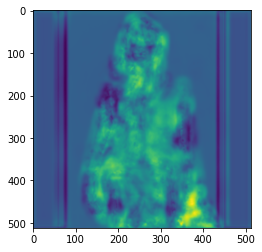

In [9]:
plt.imshow(output_np)